ARTIFICIAL LIMBS ASSIGNMENT 4

General pattern recognition pipeline


Recording:

The purpose of the first stage is to collect or record data relevant to the topic at hand. This information could originate from a variety of sources, including sensors, photographs, audio recordings, or any other type of data collecting. Recording is essential because it lays the groundwork for further analysis. The efficacy of pattern recognition is greatly influenced by the quality and quantity of recorded data.
Preprocessing:

Preprocessing is used to clean, improve, or transform raw data into an analysis-ready state. This step covers concerns like noise reduction, data normalization, and missing value handling.Properly prepared data enhances the speed and accuracy of future processing steps. Preprocessing removes artifacts from the data and ensures that it is consistent and ready for feature extraction.
Characteristics extraction:
Feature extraction is the process of extracting useful information or features from preprocessed data that best represent the underlying patterns. These features should capture the most important aspects of the data.
Appropriate feature selection is crucial for good pattern recognition. Extracted features should emphasize the unique parts of the data that are relevant to the problem while minimizing irrelevant details.
Real-Time Classification:
Real-time processing and classification may be required in some applications. This entails generating predictions or choices as new data becomes available, rather than waiting for the complete dataset to be available.
Real-time classification is critical for applications that require instant judgments, such as live monitoring or control systems.
Classifier Training:
The goal is to train a classifier on a labeled dataset before deploying it for pattern recognition. This entails feeding the classifier known input-output pairings in order for it to learn the underlying patterns and correlations. Training enables the classifier to generalize from the examples presented, allowing it to make correct predictions on new, previously unknown data. The performance of the classifier is influenced by the quality of the training data and the method used.
Test Classification:
The classifier is used to predict or categorize patterns after it has been trained. This step entails making judgments based on the patterns learned during training. Pattern recognition's ultimate goal is to accurately categorize or predict patterns in new data. The classifier's performance is measured by its ability to generalize to previously unseen examples.


In [1]:
import wfdb
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn import tree

In [2]:
# Loading data and labels
def load_data_and_labels():
    subjects = ['sample1', 'sample3', 'sample5']
    channels = [0, 1, 2]

    data_dict = {}

    for subject in subjects:
        # Load data files
        data, info = wfdb.rdsamp(f"maintenance_preprocess_{subject}")

        # Store data and info in the dictionary
        data_dict[f"{subject}_data"] = data
        data_dict[f"{subject}_info"] = info

  
    return data_dict



In [3]:
# Load Label File.
label_path = "label_maintenance.txt"
with open(label_path, 'r') as label_file:
    labels = list(map(int, label_file.read().split(',')))

Windows Extraction

In [4]:
# Function to extract windows and features with 128 window size and 50% overlap
def extract_windows_and_features(data_dict, window_size=128, overlap=0.5):
    subjects = ['sample1', 'sample3', 'sample5']
    channels = [0, 1, 2]
    num_features_per_channel = 18

    windows_dict = {}

    for subject in subjects:
        data = data_dict[f"{subject}_data"]
        signals = data[:, channels]

        
        window_step = int(window_size * (1 - overlap))
        num_windows = (signals.shape[0] - window_size) // window_step + 1

        # Initialize the 3D array to store windows and features
        windows = np.zeros((num_windows, window_size, len(channels)))
        window_features = np.zeros((num_windows, len(channels) * num_features_per_channel))

        # Extract windows and features
        for i in range(num_windows):
            start = i * window_step
            end = start + window_size
            window = signals[start:end, :]

            # Feature extraction for each channel
            for ch in range(len(channels)):
                channel_features = calculate_channel_features(window[:, ch])
                window_features[i, ch * num_features_per_channel:(ch + 1) * num_features_per_channel] = channel_features

            windows[i, :, :] = window

        windows_dict[subject] = {"windows": windows, "features": window_features[:, :num_features_per_channel]}

    return windows_dict


# Function to calculate features for each channel
def calculate_channel_features(window):
    features = []

    # Features
    mav = np.mean(np.abs(window))
    rms = np.sqrt(np.mean(window**2))
    wl = np.sum(np.abs(np.diff(window)))
    iav = np.sum(np.abs(window))
    skewness = np.mean(((window - np.mean(window)) / np.std(window))**3)
    variance = np.var(window)
    zcr = np.sum(np.diff(np.sign(window)) != 0) / (len(window) - 1)
    m2 = np.mean(np.diff(window, 2)**2)
    energy = np.sum(window**2)    
    dasdv = np.sqrt(np.mean(np.diff(window)**2))
    kurt = np.mean(((window - np.mean(window)) / np.std(window))**4)
    log_detector = np.sum(np.log(np.abs(window) + 1))
    ohm = np.sum(np.abs(np.diff(np.angle(np.fft.fft(window)))))
    mavslp = np.mean(np.abs(np.diff(window)))
    ssc = np.sum(np.diff(np.sign(np.diff(window))) != 0)
    ssi = np.sum(window**2)
    tm = np.sum(np.abs(np.diff(window))**2)
    rms_diff = np.sqrt(np.mean(np.diff(window)**2))
    
    # Selecting 18 features per channel
    features.extend([mav, rms, wl, iav, skewness, variance, zcr, m2, energy, dasdv, kurt, log_detector, ohm, mavslp, ssc, ssi, tm, rms_diff])

    # Convert features to np.float64
    features = np.asarray(features, dtype=np.float64)

    return features


# Load data and labels
loaded_data = load_data_and_labels()

# Extract windows and features
extracted_data_dict = extract_windows_and_features(loaded_data)

# Access windows and features for each subject
for subject, data in extracted_data_dict.items():
    windows = data["windows"]
    features = data["features"]
    print(f"Subject {subject}: Shape of extracted windows - {windows.shape}, Shape of extracted features - {features.shape}")


Subject sample1: Shape of extracted windows - (127, 128, 3), Shape of extracted features - (127, 18)
Subject sample3: Shape of extracted windows - (127, 128, 3), Shape of extracted features - (127, 18)
Subject sample5: Shape of extracted windows - (127, 128, 3), Shape of extracted features - (127, 18)


Removing the features with high correlation.
Features with a correlation higher than 0.9 

In [5]:
# Feature names
feature_names = ['MAV', 'RMS', 'WL', 'IAV', 'Skewness', 'Variance', 'ZCR', 'M2', 'Energy', 'DASDV', 'Kurtosis', 'LOG', 'OHM', 'MAVSLP', 'SSC', 'SSI', 'TM', 'RMS_DIFF']

# Initialize a dictionary to store modified features for each subject
modified_features_dict = {}

for subject in ['sample1', 'sample3', 'sample5']:
    # Use extracted_data_dict for features for each subject
    features_subject = extracted_data_dict[subject]['features']

    # Compute correlation matrix for the original features
    correlation_matrix_original = np.corrcoef(features_subject, rowvar=False)

    # Find features with high correlation (greater than 0.9)
    high_corr_indices = np.where(np.abs(correlation_matrix_original) > 0.9)

    # Remove features with high correlation
    features_to_keep = set(range(features_subject.shape[1]))

    for i, j in zip(*high_corr_indices):
        if i != j and i in features_to_keep and j in features_to_keep:
            features_to_keep.remove(j)

    # Ensure at least 5 features are kept
    min_features_to_keep = 5
    while len(features_to_keep) < min_features_to_keep:
        # Keep removing the highest correlated
        max_corr_index = np.unravel_index(np.argmax(np.abs(correlation_matrix_original)), correlation_matrix_original.shape)
        features_to_keep.remove(max_corr_index[1])
        correlation_matrix_original[max_corr_index] = 0  

    # Print the names of the features to keep
    final_features_to_keep = list(features_to_keep)
    feature_names_to_keep = [feature_names[i % len(feature_names)] for i in final_features_to_keep]
    print(f"\nSelected features with correlation less than 0.9 for {subject}: {feature_names_to_keep}")

    # Store the modified features for the subject
    modified_features_subject = features_subject[:, final_features_to_keep]
    modified_features_dict[subject] = {"features": modified_features_subject, "selected_feature_names": feature_names_to_keep}

    # Compute correlation matrix for the modified features
    correlation_matrix_modified = np.corrcoef(modified_features_subject, rowvar=False)

    # Print the correlation matrix for the modified features
    print(f"\nCorrelation Matrix (Modified Features) for {subject}:")
    print(correlation_matrix_modified)



Selected features with correlation less than 0.9 for sample1: ['MAV', 'Skewness', 'ZCR', 'M2', 'Kurtosis', 'OHM', 'SSC']

Correlation Matrix (Modified Features) for sample1:
[[ 1.          0.20572981 -0.3288068   0.88915315  0.18459601 -0.02623654
  -0.41235639]
 [ 0.20572981  1.         -0.07740354  0.23063235  0.20028089  0.10304953
   0.02942666]
 [-0.3288068  -0.07740354  1.         -0.02809659 -0.05259663  0.15673387
   0.09835703]
 [ 0.88915315  0.23063235 -0.02809659  1.          0.28275007  0.05335065
  -0.33037646]
 [ 0.18459601  0.20028089 -0.05259663  0.28275007  1.         -0.06942809
  -0.08163541]
 [-0.02623654  0.10304953  0.15673387  0.05335065 -0.06942809  1.
   0.10252448]
 [-0.41235639  0.02942666  0.09835703 -0.33037646 -0.08163541  0.10252448
   1.        ]]

Selected features with correlation less than 0.9 for sample3: ['MAV', 'Skewness', 'ZCR', 'Kurtosis', 'OHM', 'SSC']

Correlation Matrix (Modified Features) for sample3:
[[ 1.         -0.3061964  -0.50381358 -0

RFE

In [6]:

# Number of features to select
num_features_to_select = 4

# extract modified_features_dict  for 'sample1', 'sample3', and 'sample5'
samples = ['sample1', 'sample3', 'sample5']

# Dictionary to store RFE rankings for each subject
rfe_rankings_dict = {}

# List to store selected features for all samples
all_selected_features = []
label_path = "label_maintenance.txt"
with open(label_path, 'r') as label_file:
    labels = list(map(int, label_file.read().split(',')))
all_labels = labels
# Perform RFE for each sample
for sample in samples:
    # Get the modified features for the current sample
    modified_features = modified_features_dict[sample]['features']

    # Select the first 68 samples
    modified_features = modified_features[:68, :]

    # Get the labels for the current sample
    sample_labels = all_labels[:68]

    # Initialize LDA model
    lda = LinearDiscriminantAnalysis()

    # Initialize RFE with LDA as the estimator
    rfe = RFE(estimator=lda, n_features_to_select=num_features_to_select)

    # Fit RFE on the modified features
    rfe.fit(modified_features, sample_labels)

    # Store the feature rankings in the dictionary
    rfe_rankings_dict[sample] = rfe.ranking_

    # Add selected features to the list
    all_selected_features.extend(modified_features_dict[sample]['selected_feature_names'])

# Obtain top four common features from the list
common_features = set(feature for feature in all_selected_features if all_selected_features.count(feature) == len(samples))

# Sort features by average ranking and select the top four
selected_features_rfe = sorted(list(common_features), key=lambda x: np.mean([rfe_rankings_dict[sample][modified_features_dict[sample]['selected_feature_names'].index(x)] for sample in samples]))[:num_features_to_select]

# Remove common features from the modified_features_dict
for sample in samples:
    modified_features_dict[sample]['selected_features_rfe'] = selected_features_rfe

# Print the final selected features based on RFE
print("\nFinal selected features based on RFE:")
print(selected_features_rfe)



Final selected features based on RFE:
['MAV', 'ZCR', 'Skewness', 'Kurtosis']


Storing each feature vector

In [7]:
# Dictionary to store feature vectors for each sample
feature_vectors_sample1 = {}
feature_vectors_sample3 = {}
feature_vectors_sample5 = {}

# Iterate over each sample
for sample in samples:
    # Get the selected feature names based on RFE for the current sample
    selected_feature_names = modified_features_dict[sample]['selected_features_rfe']

    # Get the indices of selected features
    selected_feature_indices = [modified_features_dict[sample]['selected_feature_names'].index(feature) for feature in selected_feature_names]

    # Extract the corresponding columns from the modified features
    feature_vector = modified_features_dict[sample]['features'][:, selected_feature_indices]

    # Store the feature vector in the corresponding dictionary
    if sample == 'sample1':
        feature_vectors_sample1[sample] = feature_vector
    elif sample == 'sample3':
        feature_vectors_sample3[sample] = feature_vector
    elif sample == 'sample5':
        feature_vectors_sample5[sample] = feature_vector

    # Print the feature vector for the current sample
    print(f"\nFeature vector for {sample}:\n{feature_vector}")




Feature vector for sample1:
[[ 1.27111843e-02  8.66141732e-02  1.21207736e+00  5.11576915e+00]
 [ 7.91828723e-03  1.49606299e-01  1.04929745e-01  2.39863583e+00]
 [ 7.93233235e-03  1.57480315e-01  1.92020436e-01  2.53935574e+00]
 [ 9.38688004e-03  1.57480315e-01  1.85531771e-02  2.35688023e+00]
 [ 1.07663741e-02  1.65354331e-01  2.41974488e-01  2.09505155e+00]
 [ 1.13165917e-02  1.18110236e-01  5.01140803e-01  3.43676169e+00]
 [ 1.05595597e-02  1.02362205e-01  1.09165072e+00  5.33068860e+00]
 [ 1.18524130e-02  1.02362205e-01  4.44742063e-01  2.43991233e+00]
 [ 1.13591659e-02  1.18110236e-01 -1.12953464e-01  2.64040371e+00]
 [ 1.58324487e-02  1.33858268e-01 -9.33556273e-01  4.16438955e+00]
 [ 3.72050826e-02  1.10236220e-01 -1.00988924e-01  2.67877127e+00]
 [ 3.19141983e-02  1.10236220e-01 -9.90330743e-02  3.35764720e+00]
 [ 2.01119088e-02  1.18110236e-01 -1.64597176e+00  5.73502941e+00]
 [ 7.30788634e-02  1.18110236e-01  1.47123339e+00  5.97281107e+00]
 [ 8.32616628e-02  7.08661417e-02

Creating a train-test split of you feature vector with 70% of the data used for training
and 30% for testing.


In [8]:
# Select the first 68 samples for each sample
selected_samples = 68

# Create empty lists to store the feature vectors and labels for all samples
all_feature_vectors = []
all_labels = []

# Iterate over each sample
for sample_dict in [feature_vectors_sample1, feature_vectors_sample3, feature_vectors_sample5]:
    for sample, feature_vector in sample_dict.items():
        # Append the feature vector and labels to the lists
        all_feature_vectors.extend(feature_vector[:selected_samples])
        all_labels.extend([sample] * selected_samples)

# Convert the lists to NumPy arrays
all_feature_vectors = np.array(all_feature_vectors)
all_labels = np.array(all_labels)

# Split the data into training (70%) and testing (30%) for all samples
X_train, X_test, y_train, y_test = train_test_split(
    all_feature_vectors, all_labels, test_size=0.3, random_state=42
)

# Print the shapes to verify consistency
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", len(y_train))
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", len(y_test))


Shape of X_train: (142, 4)
Shape of y_train: 142
Shape of X_test: (62, 4)
Shape of y_test: 62


Support Vector Machine (SVM)


SVM works by mapping data to a high-dimensional feature space in order to categorize data points that are otherwise not linearly separable. 
CORE PRINCIPLES.
Hyperplane - This is a straight line in two dimensions that splits data into two classes. In higher-dimensional spaces, a hyperplane becomes a multidimensional linear decision boundary.

Support vectors - support vectors are defined as data points that are closest to the decision boundary (hyperplane) and have a direct influence on identifying the best hyperplane. These are the important points for defining the decision limit.

Margin -The margin is the distance between the hyperplane and the nearest data point from each class (support vector). SVM seeks to maximize this margin by offering a clear separation between classes. A greater margin often leads to better generalization to unknown data.

Kernel - The kernel allows SVMs to handle non-linear decision boundaries efficiently. Kernels enable the algorithm to implicitly transfer the input data into higher-dimensional spaces, where non-linear relationships can be represented as linear ones. 
C parameter - The regularization parameter (C) in SVM governs the trade-off between achieving a smooth decision border and correctly classifying the training points. A smaller C prioritizes a smoother decision border, whereas a bigger C seeks to correctly categorize all training points, perhaps resulting in a more complex boundary.


Creating a train-test split of you feature vector with 70% of the data used for training
and 30% for testing.


In [9]:
# Initialize the SVM classifier
clf = SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy * 100, "%")


Accuracy: 43.54838709677419 %


linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) is a supervised method for reducing the number of dimensions in a dataset. Its goal is to maximize the distinction between different classes. This is achieved by identifying a set of linear discriminants that maximize the ratio of variation across classes to variance within classes. The objective is to map the data onto a lower-dimensional space, maximizing the distance between different classes. LDA is classified as a supervised algorithm due to its utilization of class labels throughout the learning phase.

Linear Discriminant Analysis (LDA) is highly advantageous when the objective is to distinguish between numerous classes while preserving the inherent structure of the data. Linear Discriminant Analysis (LDA) ensures that the reduced-dimensional representation effectively preserves the important characteristics needed for distinguishing between different classes. It achieves this by emphasizing the differences in variance across classes and limiting the variation within each class. As a result, LDA is highly useful in solving classification and pattern recognition problems.



Accuracy (LDA): 54.83870967741935 %


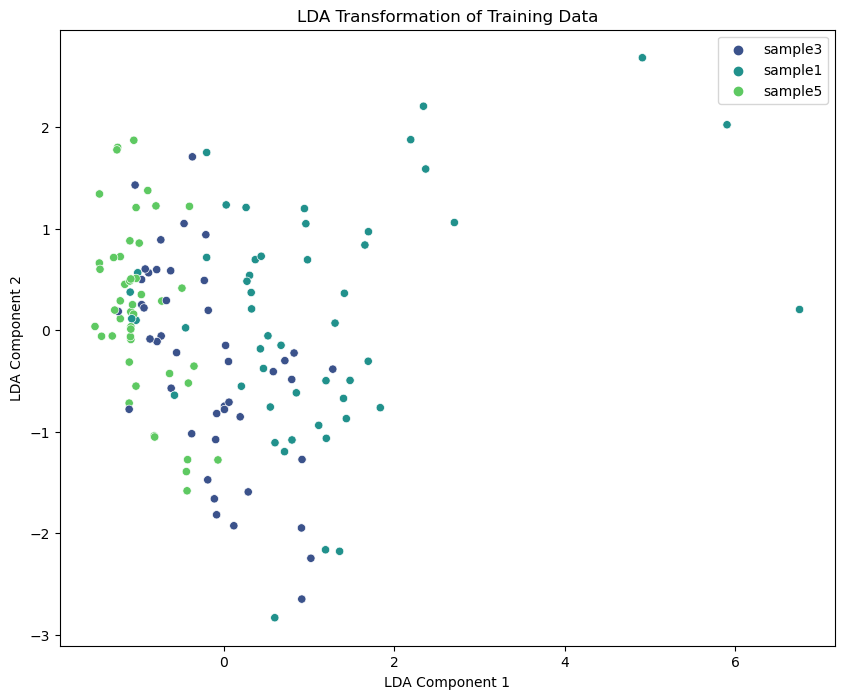

In [10]:


# Initialize the LDA classifier
lda = LinearDiscriminantAnalysis()

# Train the classifier
lda.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lda = lda.predict(X_test)

# Evaluate the accuracy
accuracy_lda = accuracy_score(y_test, y_pred_lda)

# Print the accuracy
print("Accuracy (LDA):", accuracy_lda * 100, "%")

# Plot the transformation of training data
X_lda = lda.transform(X_train)

# Create a scatter plot with seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=y_train, palette='viridis', legend='full')
plt.title('LDA Transformation of Training Data')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()


Random Forest

Random Forest is an ensemble learning method that constructs many decision trees and combines their predictions to provide robust results. The primary idea is to generate a diversified set of decision trees from the original dataset using bootstrapped sampling. A random subset of variables is examined for splitting at each node, increasing individual tree variety. Random Forest avoids overfitting and increases generalization performance by aggregating predictions from numerous trees. This iterative process of bootstrapping and random variable selection yields a robust and versatile ensemble model noted for its noise resistance and accuracy in a variety of tasks.

Accuracy (Random Forest): 74.19354838709677 %


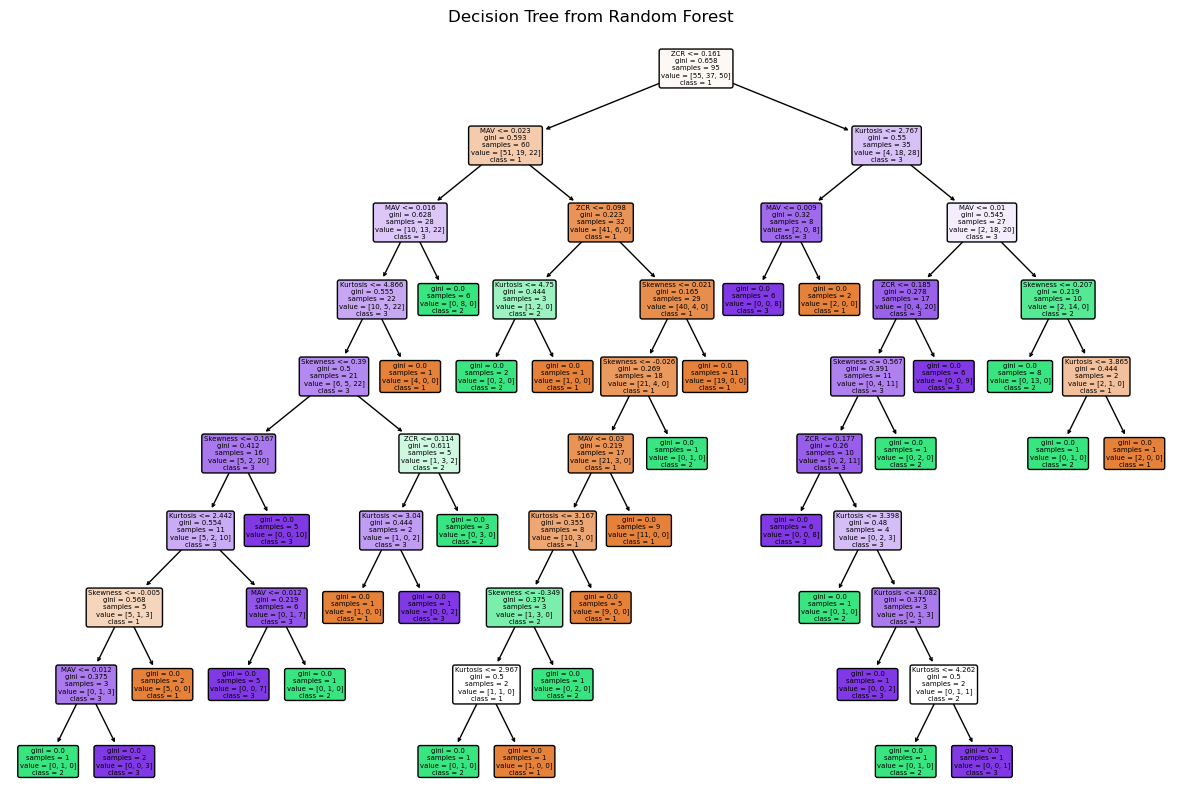

In [11]:

# Initialize the Random Forest classifier with 100 decision trees
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Print the accuracy
print("Accuracy (Random Forest):", accuracy_rf * 100, "%")

# Plot one of the decision trees (e.g., the first tree)
plt.figure(figsize=(15, 10))
tree.plot_tree(rf_classifier.estimators_[0], feature_names=modified_features_dict[samples[0]]['selected_features_rfe'], class_names=[str(i) for i in range(1, 35)], filled=True, rounded=True)
plt.title('Decision Tree from Random Forest')
plt.show()


Results Evaluation.

The results from various classifiers shows differing levels of accuracy in the pattern recognition challenge. SVM had the lowest accuracy of  43.55%, suggesting a moderate degree of performance. SVM is well-known for its ability to handle complex decision boundaries, however, its performance could be slightly affected by parameter selection and data type of our sEMG signal.

The second classffier had an accuracy of 54.84%.  While LDA outperformed the SVM in this situation, its accuracy remains is slightly above average. However, its perfromance could be affacted due to its linear characteristics implying that the data may not be well-separated by linear decision boundaries.

The Random Forest classifier, on the other hand, had the highest accuracy of the three, reaching 70.97%. Random Forest is a superior ensemble learning method that combines the predictions of several decision trees. Random Forest's higher accuracy can be attributed to its capacity to grasp complicated correlations in data and minimize overfitting. Due to its greater accuracy, the Random Forest classifier appears to be the most promising for this task. 
However, other considerations such as interpretability, computational efficiency, and the application's specific requirements must be considered. It is advised that the classifiers be evaluated further using additional metrics such as precision, recall, and F1-score to acquire a full understanding of their performance in various aspects. Furthermore, fine-tuning the parameters of each classifier may be requoired to evaluate their performance.